#### 1. 패키지 로딩하기

In [89]:
import os
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from IPython.display import Image
from catboost import CatBoostRegressor

#### 2. 데이터 불러오기

* 2_1. 데이터 경로 지정하기

In [2]:
train_path      = os.getenv("HOME") + "/aiffel/competitive-data-science-predict-future-sales/sales_train.csv"
test_path       = os.getenv("HOME") + "/aiffel/competitive-data-science-predict-future-sales/test.csv"
submission_path = os.getenv("HOME") + "/aiffel/competitive-data-science-predict-future-sales/sample_submission.csv"

* 2_2. 데이터 읽어오기

In [3]:
train_data      = pd.read_csv(filepath_or_buffer = train_path)
test_data       = pd.read_csv(filepath_or_buffer = test_path)
submission_data = pd.read_csv(filepath_or_buffer = submission_path)

#### 3. 데이터 살펴보기

* 3_1. 훈련 데이터

In [4]:
train_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


* 3_2. 테스트 데이터

In [5]:
test_data.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


* 3_3. 제출 양식

In [6]:
submission_data.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


* 3_4. 각 파일의 shape / info

In [7]:
print(train_data.shape)
print(test_data.shape)
print(submission_data.shape)

(2935849, 6)
(214200, 3)
(214200, 2)


In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [9]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB


#### 4. 데이터 전처리

* 4_1. 결측치 유무 확인하기

In [10]:
for c in train_data.columns:
    print("{} : {}".format(c, len(train_data.loc[pd.isnull(train_data[c]), c].values)))

date : 0
date_block_num : 0
shop_id : 0
item_id : 0
item_price : 0
item_cnt_day : 0


In [11]:
for c in test_data.columns:
    print("{} : {}".format(c, len(test_data.loc[pd.isnull(test_data[c]), c].values)))

ID : 0
shop_id : 0
item_id : 0


<AxesSubplot:>

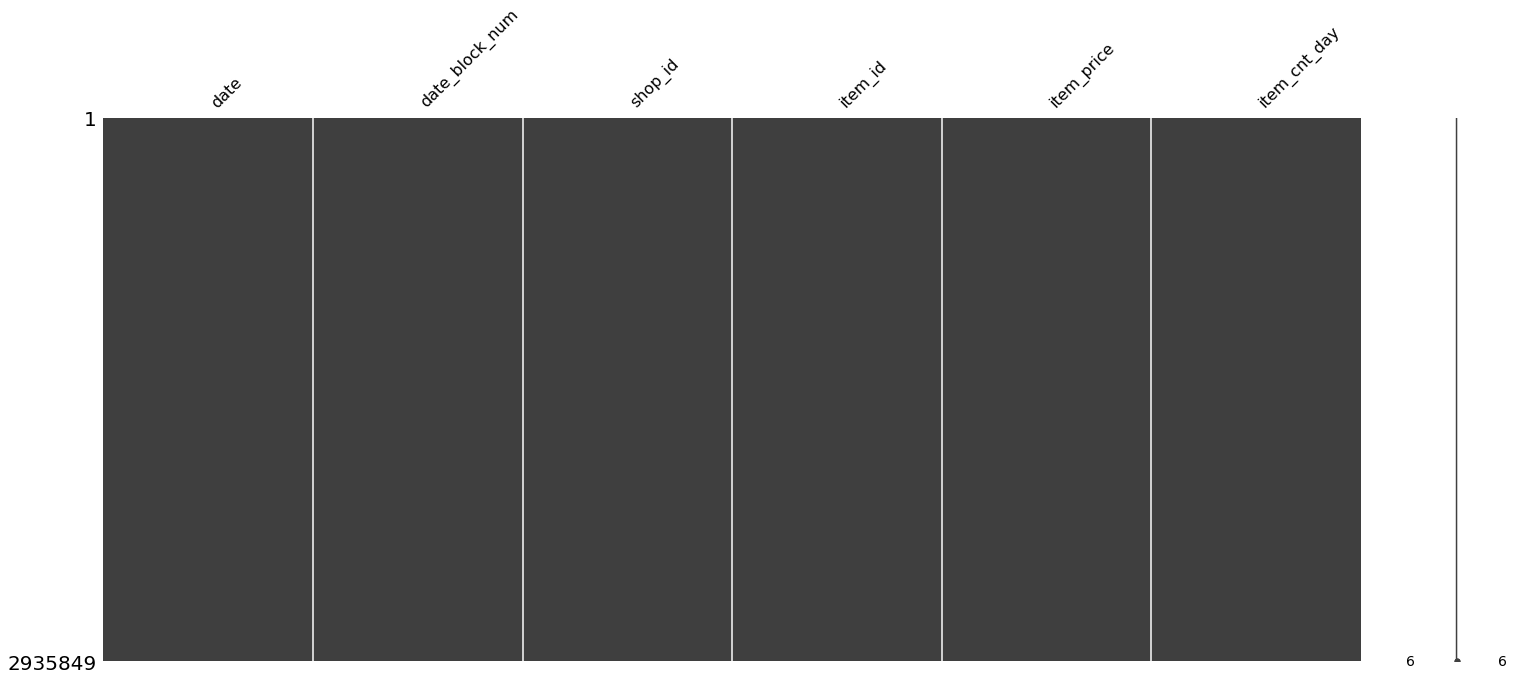

In [12]:
msno.matrix(train_data)

<AxesSubplot:>

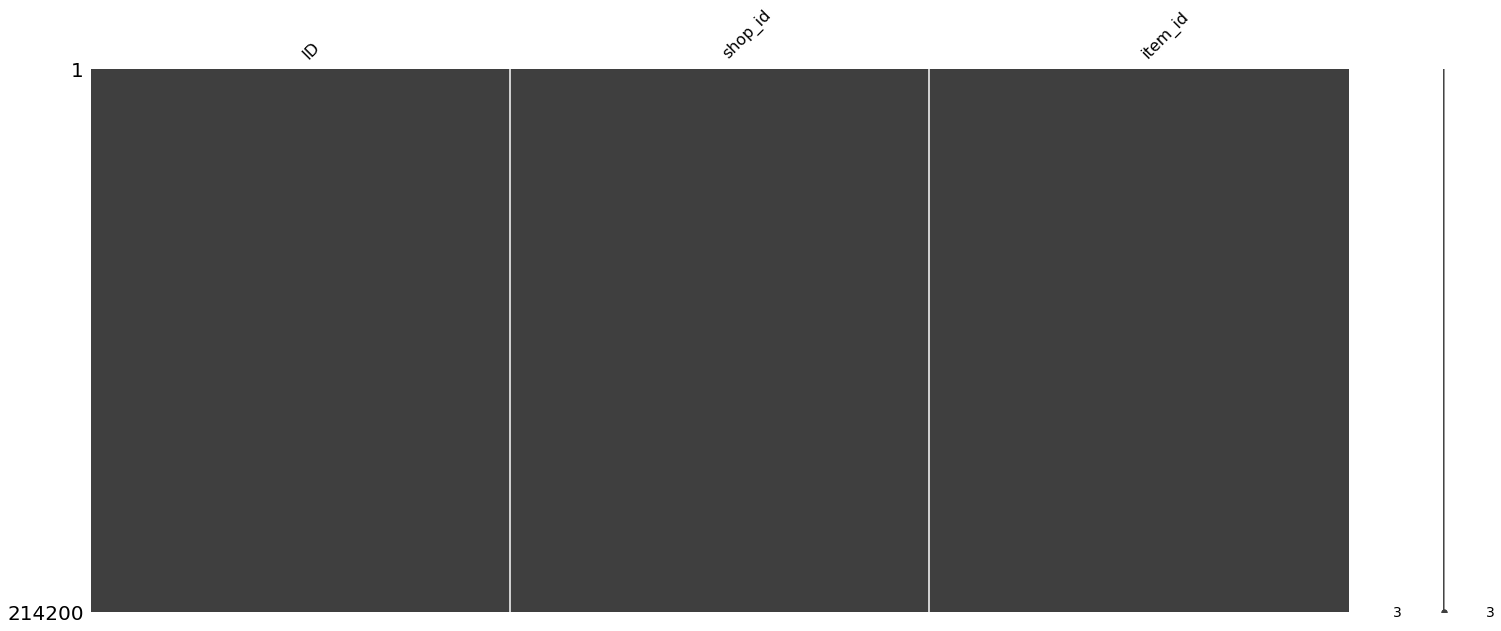

In [13]:
msno.matrix(test_data)

* 4_2. date 칼럼 수정하기

In [14]:
train_data["date"] = train_data["date"].apply(lambda x : datetime.datetime.strptime(x, "%d.%m.%Y"))

In [15]:
train_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


* 4_3. 칼럼 분포 확인하기

In [16]:
# "x"에 따른 판매량 그래프 그리는 함수
def get_plot(x : list):
    temp              = train_data.groupby(x)["item_cnt_day"].sum()
    temp.plot(figsize = (10, 10))

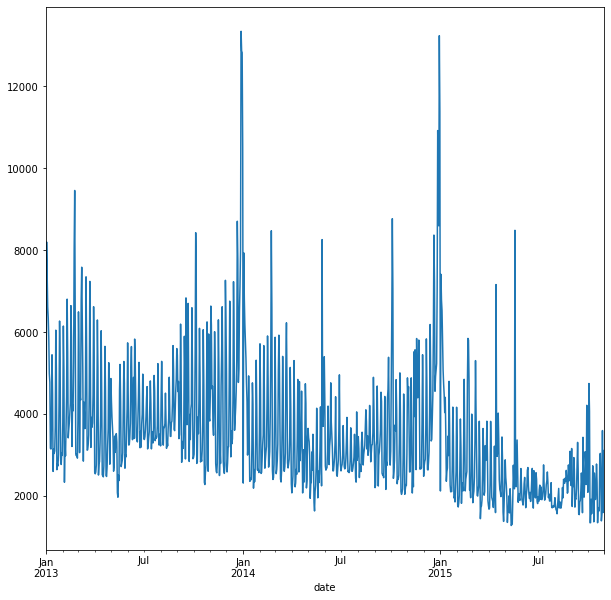

In [17]:
# 일자별 판매량
get_plot("date")

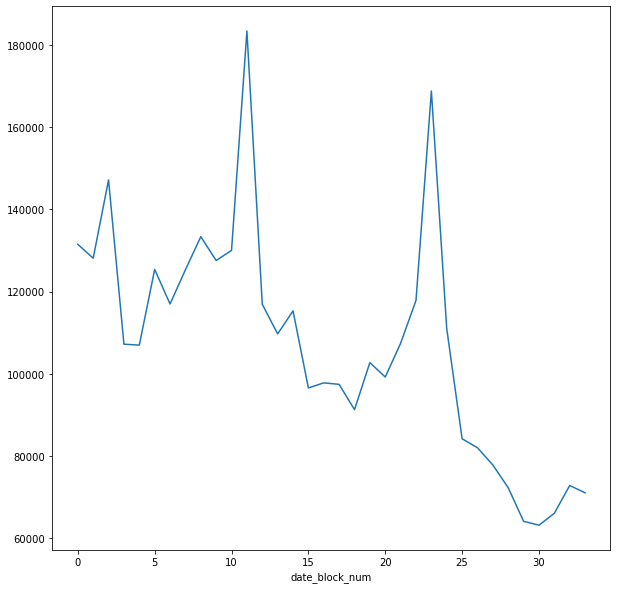

In [18]:
# 월별에 따른 판매량
get_plot("date_block_num")

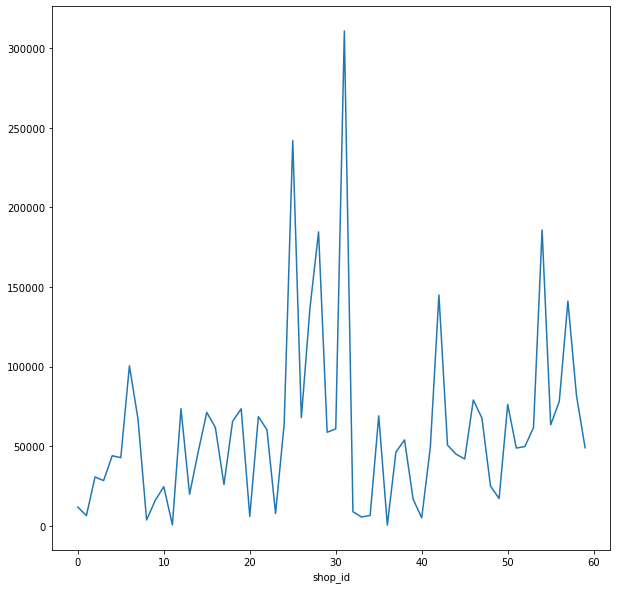

In [19]:
# 가계에 따른 판매량
get_plot("shop_id")

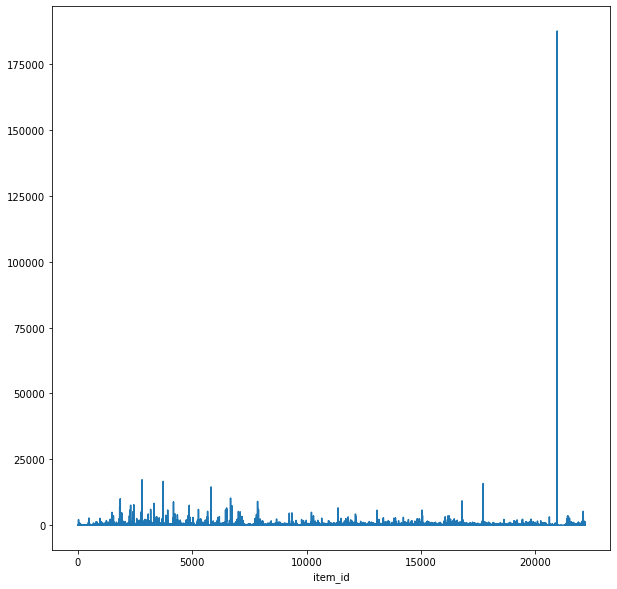

In [20]:
# 아이템에 따른 판매량
get_plot("item_id")

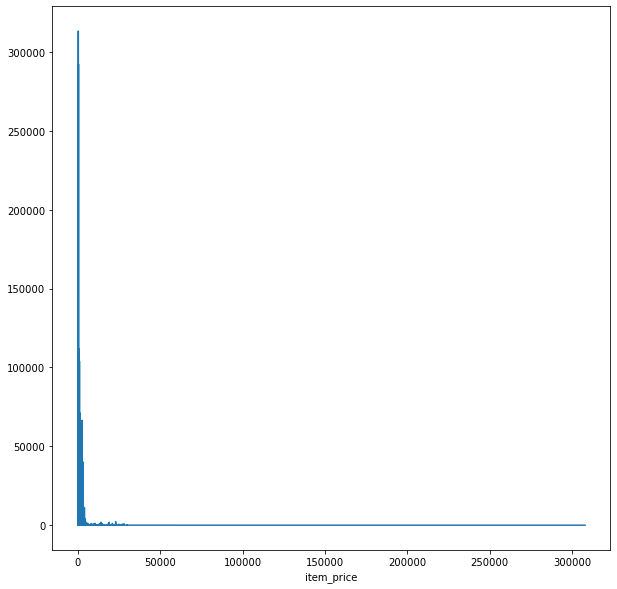

In [21]:
# 가격별 판매량
get_plot("item_price")

* 4_4. 훈련 데이터 변수별 이상치 확인하기

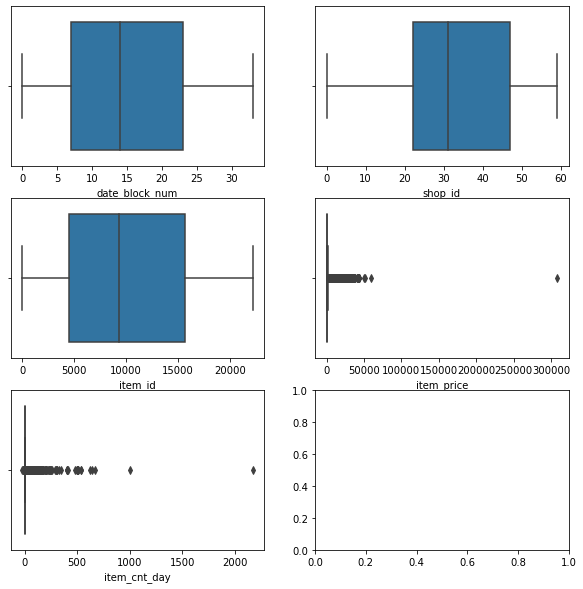

In [22]:
fig, ax = plt.subplots(3, 2, figsize = (10, 10))

count   = 1
columns = train_data.columns
try:
    for row in range(3):
        for col in range(2):
            sns.boxplot(x = columns[count], data = train_data, ax = ax[row][col])
            count += 1
except IndexError:
    pass

* 4_5. 훈련 데이터별 분포 확인하기

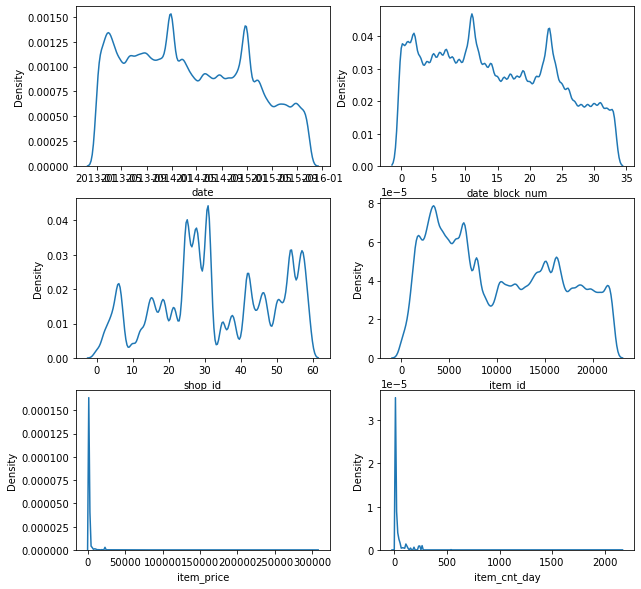

In [23]:
fig, ax = plt.subplots(3, 2, figsize = (10, 10))

count   = 0
columns = train_data.columns

for row in range(3):
    for col in range(2):
        sns.kdeplot(train_data[columns[count]], ax = ax[row][col])
        count += 1

* 4_6. 데이터 이상치 탐색 및 제거

In [24]:
train_data[train_data["item_price"] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,2013-05-15,4,32,2973,-1.0,1.0


In [25]:
train_data[train_data["item_price"] > 300000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,2013-12-13,11,12,6066,307980.0,1.0


In [26]:
train_data[train_data["item_cnt_day"] > 2000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2909818,2015-10-28,33,12,11373,0.908714,2169.0


In [27]:
train_data[train_data["item_cnt_day"] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2,2013-01-05,0,25,2552,899.0,-1.0
148,2013-01-23,0,25,2321,999.0,-1.0
175,2013-01-07,0,25,2199,1449.0,-1.0
807,2013-01-02,0,25,2330,599.0,-1.0
1041,2013-01-13,0,25,5034,1989.0,-1.0
...,...,...,...,...,...,...
2934243,2015-10-26,33,25,3917,449.0,-1.0
2934462,2015-10-18,33,25,4896,6398.0,-1.0
2935263,2015-10-05,33,25,10039,249.0,-1.0
2935643,2015-10-16,33,25,7893,2990.0,-1.0


In [28]:
index      = train_data[train_data["item_price"] < 0].index
train_data = train_data.drop(index)

In [29]:
index      = train_data[train_data["item_price"] > 300000].index
train_data = train_data.drop(index)

In [30]:
index      = train_data[train_data["item_cnt_day"] > 2000].index
train_data = train_data.drop(index)

In [31]:
index      = train_data[train_data["item_cnt_day"] < 0].index
train_data = train_data.drop(index)

In [32]:
train_data[train_data["item_price"] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


In [33]:
train_data[train_data["item_price"] > 300000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


In [34]:
train_data[train_data["item_cnt_day"] > 2000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


In [35]:
train_data[train_data["item_cnt_day"] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


In [36]:
train_data

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
5,2013-01-10,0,25,2564,349.00,1.0
...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0
2935845,2015-10-09,33,25,7460,299.00,1.0
2935846,2015-10-14,33,25,7459,349.00,1.0
2935847,2015-10-22,33,25,7440,299.00,1.0


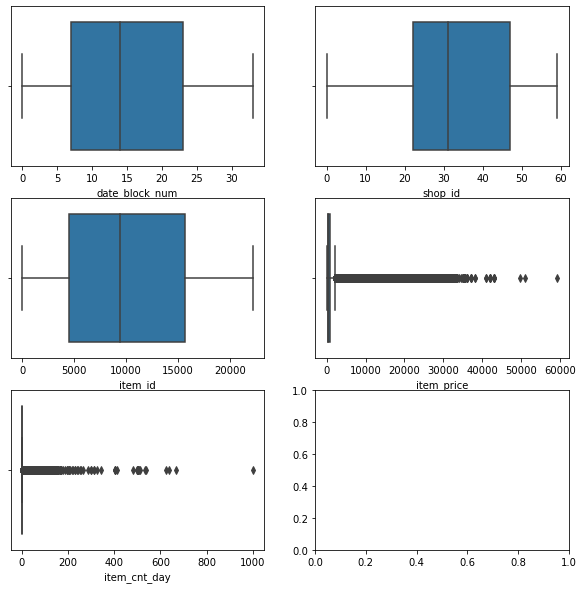

In [37]:
fig, ax = plt.subplots(3, 2, figsize = (10, 10))

count = 1
columns = train_data.columns
try:
    for row in range(3):
        for col in range(2):
            sns.boxplot(x = columns[count], data = train_data, ax = ax[row][col])
            count += 1
except IndexError:
    pass

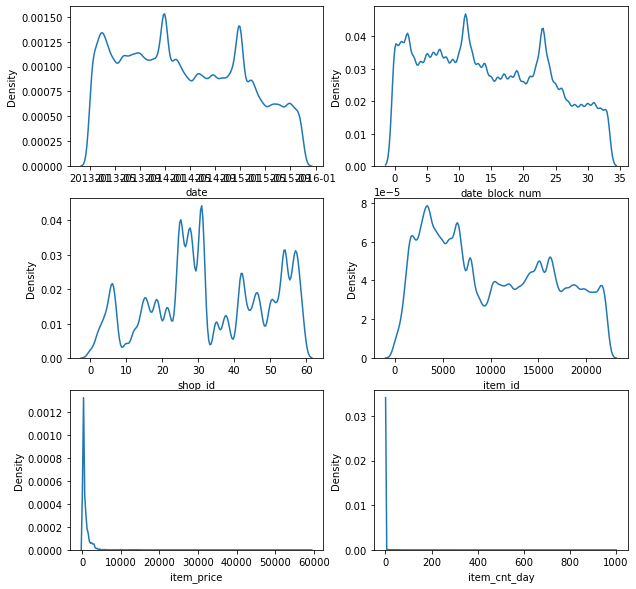

In [53]:
fig, ax = plt.subplots(3, 2, figsize = (10, 10))

count   = 0
columns = train_data.columns

for row in range(3):
    for col in range(2):
        sns.kdeplot(train_data[columns[count]], ax = ax[row][col])
        count += 1

#### 5. feature, label 분리하기

In [38]:
month_train_data = train_data.groupby(["date_block_num", "shop_id", "item_id"], as_index = False).agg({"item_cnt_day" : "sum"})
month_train_data.head(10)

,date_block_num,shop_id,item_id,item_cnt_day
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0
5,0,0,61,1.0
6,0,0,75,1.0
7,0,0,88,1.0
8,0,0,95,1.0
9,0,0,96,1.0


In [39]:
train = month_train_data.iloc[:, :-1]
train

,date_block_num,shop_id,item_id
0,0,0,32
1,0,0,33
2,0,0,35
3,0,0,43
4,0,0,51
...,...,...,...
1608220,33,59,22087
1608221,33,59,22088
1608222,33,59,22091
1608223,33,59,22100


In [40]:
y = month_train_data.iloc[:, -1]
y

0          6.0
1          3.0
2          1.0
3          1.0
4          2.0
          ... 
1608220    6.0
1608221    2.0
1608222    1.0
1608223    1.0
1608224    1.0
Name: item_cnt_day, Length: 1608225, dtype: float64

In [41]:
print(train.shape)
print(y.shape)

(1608225, 3)
(1608225,)


#### 6. 훈련 데이터와 테스트 데이터 변수 정리하기

In [42]:
del test_data["ID"]
test_data

,shop_id,item_id
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268
...,...,...
214195,45,18454
214196,45,16188
214197,45,15757
214198,45,19648


In [43]:
del train["date_block_num"]
train

,shop_id,item_id
0,0,32
1,0,33
2,0,35
3,0,43
4,0,51
...,...,...
1608220,59,22087
1608221,59,22088
1608222,59,22091
1608223,59,22100


In [44]:
y

0          6.0
1          3.0
2          1.0
3          1.0
4          2.0
          ... 
1608220    6.0
1608221    2.0
1608222    1.0
1608223    1.0
1608224    1.0
Name: item_cnt_day, Length: 1608225, dtype: float64

#### 7. feature, y 분포 확인하기

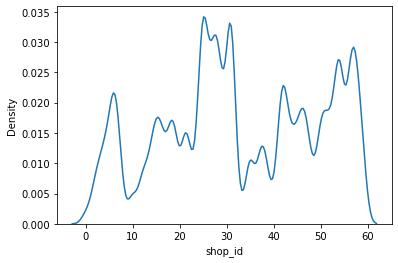

In [45]:
sns.kdeplot(train["shop_id"])
plt.show()

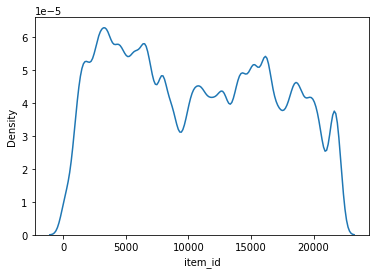

In [46]:
sns.kdeplot(train["item_id"])
plt.show()

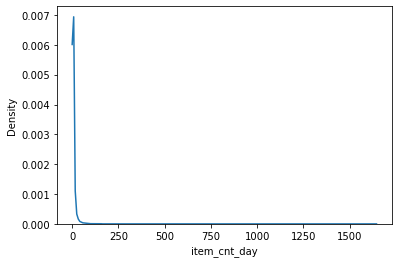

In [47]:
sns.kdeplot(y)
plt.show()

In [48]:
y = np.log1p(y)

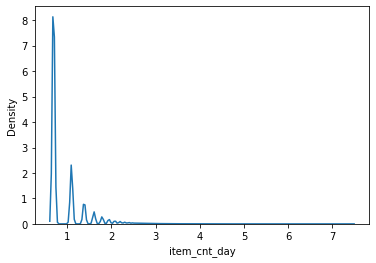

In [49]:
sns.kdeplot(y)
plt.show()

#### 8. 모델을 구성하고 학습 및 예측하기

In [79]:
cbr = CatBoostRegressor()
cbr.fit(train, y)

Learning rate set to 0.145255
0:	learn: 0.4866733	total: 116ms	remaining: 1m 56s
1:	learn: 0.4851738	total: 187ms	remaining: 1m 33s
2:	learn: 0.4839252	total: 250ms	remaining: 1m 23s
3:	learn: 0.4830934	total: 317ms	remaining: 1m 19s
4:	learn: 0.4819939	total: 386ms	remaining: 1m 16s
5:	learn: 0.4813202	total: 460ms	remaining: 1m 16s
6:	learn: 0.4806702	total: 525ms	remaining: 1m 14s
7:	learn: 0.4798870	total: 583ms	remaining: 1m 12s
8:	learn: 0.4793678	total: 651ms	remaining: 1m 11s
9:	learn: 0.4790023	total: 726ms	remaining: 1m 11s
10:	learn: 0.4785645	total: 791ms	remaining: 1m 11s
11:	learn: 0.4781286	total: 858ms	remaining: 1m 10s
12:	learn: 0.4777246	total: 919ms	remaining: 1m 9s
13:	learn: 0.4774504	total: 987ms	remaining: 1m 9s
14:	learn: 0.4770615	total: 1.05s	remaining: 1m 9s
15:	learn: 0.4764612	total: 1.11s	remaining: 1m 8s
16:	learn: 0.4760919	total: 1.17s	remaining: 1m 7s
17:	learn: 0.4758719	total: 1.25s	remaining: 1m 8s
18:	learn: 0.4755341	total: 1.3s	remaining: 1m 7s


163:	learn: 0.4606369	total: 11.2s	remaining: 57.3s
164:	learn: 0.4606107	total: 11.3s	remaining: 57.3s
165:	learn: 0.4605510	total: 11.4s	remaining: 57.2s
166:	learn: 0.4605028	total: 11.5s	remaining: 57.2s
167:	learn: 0.4604522	total: 11.5s	remaining: 57.1s
168:	learn: 0.4604255	total: 11.6s	remaining: 57s
169:	learn: 0.4603713	total: 11.7s	remaining: 56.9s
170:	learn: 0.4603551	total: 11.7s	remaining: 56.8s
171:	learn: 0.4603446	total: 11.8s	remaining: 56.7s
172:	learn: 0.4603116	total: 11.9s	remaining: 56.7s
173:	learn: 0.4602363	total: 11.9s	remaining: 56.6s
174:	learn: 0.4601879	total: 12s	remaining: 56.6s
175:	learn: 0.4601283	total: 12.1s	remaining: 56.5s
176:	learn: 0.4600912	total: 12.1s	remaining: 56.5s
177:	learn: 0.4600560	total: 12.2s	remaining: 56.3s
178:	learn: 0.4600470	total: 12.3s	remaining: 56.2s
179:	learn: 0.4600214	total: 12.3s	remaining: 56.1s
180:	learn: 0.4600013	total: 12.4s	remaining: 56.2s
181:	learn: 0.4599633	total: 12.5s	remaining: 56.2s
182:	learn: 0.45

322:	learn: 0.4568674	total: 22.3s	remaining: 46.7s
323:	learn: 0.4568559	total: 22.3s	remaining: 46.6s
324:	learn: 0.4568440	total: 22.4s	remaining: 46.5s
325:	learn: 0.4568317	total: 22.4s	remaining: 46.4s
326:	learn: 0.4568189	total: 22.5s	remaining: 46.3s
327:	learn: 0.4568066	total: 22.6s	remaining: 46.3s
328:	learn: 0.4567964	total: 22.6s	remaining: 46.2s
329:	learn: 0.4566879	total: 22.7s	remaining: 46.1s
330:	learn: 0.4566765	total: 22.8s	remaining: 46.1s
331:	learn: 0.4566665	total: 22.8s	remaining: 46s
332:	learn: 0.4566585	total: 22.9s	remaining: 45.9s
333:	learn: 0.4566366	total: 23s	remaining: 45.8s
334:	learn: 0.4566207	total: 23.1s	remaining: 45.8s
335:	learn: 0.4566133	total: 23.1s	remaining: 45.7s
336:	learn: 0.4566005	total: 23.2s	remaining: 45.6s
337:	learn: 0.4565907	total: 23.2s	remaining: 45.5s
338:	learn: 0.4565846	total: 23.3s	remaining: 45.4s
339:	learn: 0.4565704	total: 23.4s	remaining: 45.4s
340:	learn: 0.4564537	total: 23.4s	remaining: 45.3s
341:	learn: 0.45

482:	learn: 0.4550434	total: 32.9s	remaining: 35.2s
483:	learn: 0.4550392	total: 32.9s	remaining: 35.1s
484:	learn: 0.4550347	total: 33s	remaining: 35s
485:	learn: 0.4550197	total: 33.1s	remaining: 35s
486:	learn: 0.4550154	total: 33.1s	remaining: 34.9s
487:	learn: 0.4550106	total: 33.2s	remaining: 34.8s
488:	learn: 0.4550076	total: 33.2s	remaining: 34.7s
489:	learn: 0.4550029	total: 33.3s	remaining: 34.7s
490:	learn: 0.4550002	total: 33.4s	remaining: 34.6s
491:	learn: 0.4549953	total: 33.4s	remaining: 34.5s
492:	learn: 0.4549918	total: 33.5s	remaining: 34.4s
493:	learn: 0.4549864	total: 33.6s	remaining: 34.4s
494:	learn: 0.4549794	total: 33.6s	remaining: 34.3s
495:	learn: 0.4549746	total: 33.7s	remaining: 34.2s
496:	learn: 0.4549670	total: 33.8s	remaining: 34.2s
497:	learn: 0.4549642	total: 33.8s	remaining: 34.1s
498:	learn: 0.4549575	total: 33.9s	remaining: 34s
499:	learn: 0.4549511	total: 34s	remaining: 34s
500:	learn: 0.4549489	total: 34s	remaining: 33.9s
501:	learn: 0.4549458	tota

643:	learn: 0.4540271	total: 43.3s	remaining: 24s
644:	learn: 0.4540251	total: 43.4s	remaining: 23.9s
645:	learn: 0.4540201	total: 43.5s	remaining: 23.8s
646:	learn: 0.4540185	total: 43.5s	remaining: 23.7s
647:	learn: 0.4540160	total: 43.6s	remaining: 23.7s
648:	learn: 0.4540128	total: 43.6s	remaining: 23.6s
649:	learn: 0.4539990	total: 43.7s	remaining: 23.5s
650:	learn: 0.4539874	total: 43.8s	remaining: 23.5s
651:	learn: 0.4539838	total: 43.8s	remaining: 23.4s
652:	learn: 0.4539776	total: 43.9s	remaining: 23.3s
653:	learn: 0.4539694	total: 44s	remaining: 23.3s
654:	learn: 0.4539669	total: 44s	remaining: 23.2s
655:	learn: 0.4539625	total: 44.1s	remaining: 23.1s
656:	learn: 0.4539599	total: 44.2s	remaining: 23.1s
657:	learn: 0.4539497	total: 44.2s	remaining: 23s
658:	learn: 0.4539455	total: 44.3s	remaining: 22.9s
659:	learn: 0.4539420	total: 44.3s	remaining: 22.8s
660:	learn: 0.4539385	total: 44.4s	remaining: 22.8s
661:	learn: 0.4539334	total: 44.5s	remaining: 22.7s
662:	learn: 0.453927

802:	learn: 0.4533781	total: 53.3s	remaining: 13.1s
803:	learn: 0.4533493	total: 53.4s	remaining: 13s
804:	learn: 0.4533458	total: 53.5s	remaining: 13s
805:	learn: 0.4533442	total: 53.5s	remaining: 12.9s
806:	learn: 0.4533422	total: 53.6s	remaining: 12.8s
807:	learn: 0.4533405	total: 53.7s	remaining: 12.8s
808:	learn: 0.4533386	total: 53.7s	remaining: 12.7s
809:	learn: 0.4533344	total: 53.8s	remaining: 12.6s
810:	learn: 0.4533319	total: 53.8s	remaining: 12.5s
811:	learn: 0.4533297	total: 53.9s	remaining: 12.5s
812:	learn: 0.4533248	total: 54s	remaining: 12.4s
813:	learn: 0.4533221	total: 54s	remaining: 12.3s
814:	learn: 0.4533203	total: 54.1s	remaining: 12.3s
815:	learn: 0.4533190	total: 54.2s	remaining: 12.2s
816:	learn: 0.4533172	total: 54.2s	remaining: 12.1s
817:	learn: 0.4533144	total: 54.3s	remaining: 12.1s
818:	learn: 0.4533134	total: 54.4s	remaining: 12s
819:	learn: 0.4533104	total: 54.4s	remaining: 11.9s
820:	learn: 0.4533073	total: 54.5s	remaining: 11.9s
821:	learn: 0.4533036	

965:	learn: 0.4528560	total: 1m 3s	remaining: 2.24s
966:	learn: 0.4528507	total: 1m 3s	remaining: 2.17s
967:	learn: 0.4528492	total: 1m 3s	remaining: 2.1s
968:	learn: 0.4528461	total: 1m 3s	remaining: 2.04s
969:	learn: 0.4528412	total: 1m 3s	remaining: 1.97s
970:	learn: 0.4528375	total: 1m 3s	remaining: 1.91s
971:	learn: 0.4528364	total: 1m 3s	remaining: 1.84s
972:	learn: 0.4528341	total: 1m 3s	remaining: 1.77s
973:	learn: 0.4528327	total: 1m 4s	remaining: 1.71s
974:	learn: 0.4528305	total: 1m 4s	remaining: 1.64s
975:	learn: 0.4528275	total: 1m 4s	remaining: 1.58s
976:	learn: 0.4528240	total: 1m 4s	remaining: 1.51s
977:	learn: 0.4528224	total: 1m 4s	remaining: 1.45s
978:	learn: 0.4528195	total: 1m 4s	remaining: 1.38s
979:	learn: 0.4528172	total: 1m 4s	remaining: 1.31s
980:	learn: 0.4528127	total: 1m 4s	remaining: 1.25s
981:	learn: 0.4528111	total: 1m 4s	remaining: 1.18s
982:	learn: 0.4528081	total: 1m 4s	remaining: 1.12s
983:	learn: 0.4528063	total: 1m 4s	remaining: 1.05s
984:	learn: 0

In [80]:
y_pred = cbr.predict(test_data)
y_pred

array([0.98250217, 0.90015109, 1.03749425, ..., 0.79352156, 0.7853339 ,
       0.85575226])

In [84]:
y_pred = np.expm1(y_pred)
y_pred

array([1.67113151, 1.45997476, 1.82213657, ..., 1.2111695 , 1.19313911,
       1.35314388])

#### 10. 예측한 값 제출하기

In [86]:
submission_data = pd.read_csv(filepath_or_buffer = submission_path)
submission_data

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5
...,...,...
214195,214195,0.5
214196,214196,0.5
214197,214197,0.5
214198,214198,0.5


In [87]:
submission_data["item_cnt_month"] = y_pred
submission_data

,ID,item_cnt_month
0,0,1.671132
1,1,1.459975
2,2,1.822137
3,3,1.822137
4,4,1.911835
...,...,...
214195,214195,1.360759
214196,214196,1.483385
214197,214197,1.211170
214198,214198,1.193139


In [88]:
submission_csv_path = os.getenv("HOME") + "/aiffel/competitive-data-science-predict-future-sales/submission_log.csv"
submission_data.to_csv(submission_csv_path, index = False)

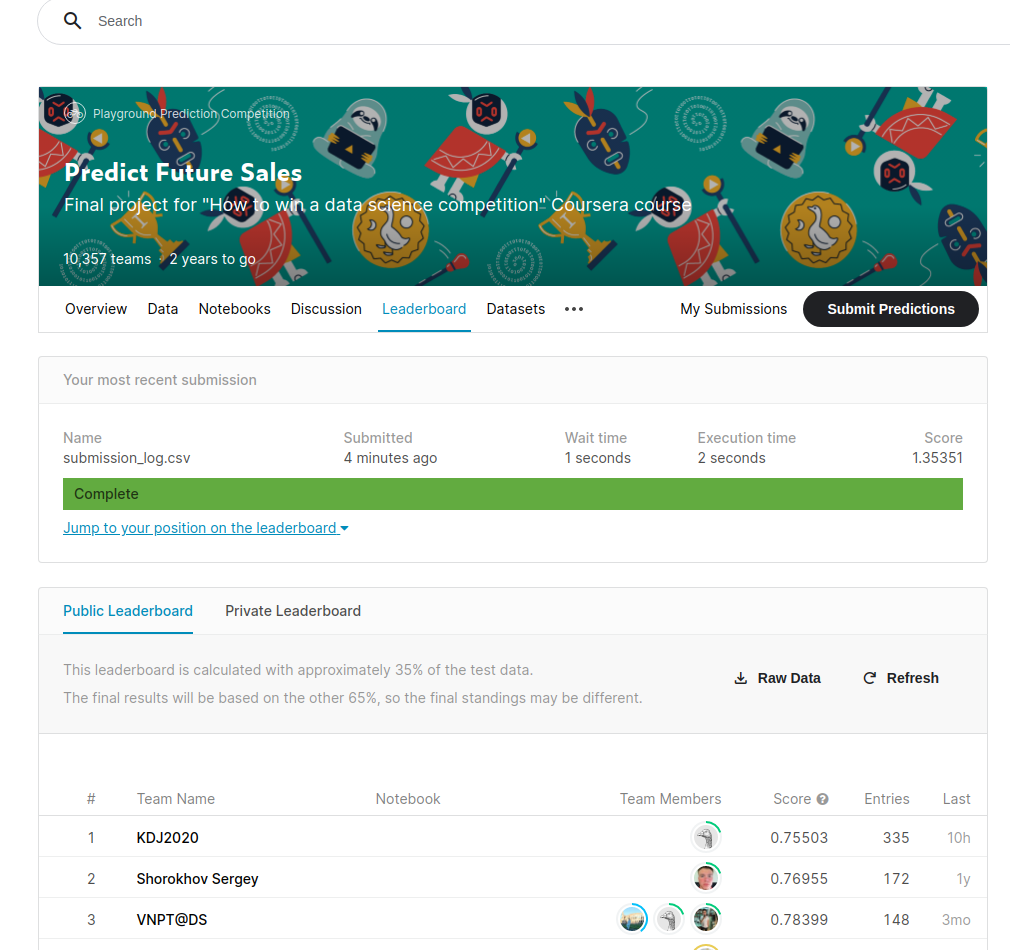

In [90]:
# Team name : 10jo
image_path = os.getenv("HOME") + "/aiffel/competitive-data-science-predict-future-sales/kaggle_score.png"
Image(image_path)